In [0]:
import math
import pandas as pd
import numpy as np
import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers
import collections
from sklearn import preprocessing
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_
  
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    
# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=0, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()    
    

def perturbation_rank(model, x, y, names, regression):
    errors = []

    for i in range(x.shape[1]):
        hold = np.array(x[:, i])
        np.random.shuffle(x[:, i])
        
        if regression:
            pred = model.predict(x)
            error = metrics.mean_squared_error(y, pred)
        else:
            pred = model.predict_proba(x)
            error = metrics.log_loss(y, pred)
            
        errors.append(error)
        x[:, i] = hold
        
    max_error = np.max(errors)
    importance = [e/max_error for e in errors]

    data = {'name':names,'error':errors,'importance':importance}
    result = pd.DataFrame(data, columns = ['name','error','importance'])
    result.sort_values(by=['importance'], ascending=[0], inplace=True)
    result.reset_index(inplace=True, drop=True)
    return result
  
  # Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
      
def class_connection(x):
  if(x=='normal.'):
    x=0
  else:
    x=1
  return x
    

In [113]:
#Reading data from csv
df_network = pd.read_csv('network_intrusion_data.csv', encoding="utf-8")
df_network.shape

(494020, 42)

In [0]:
#Titles for dataframe
df_network.columns = [
 'duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'outcome'
]
df_network[0:5]
df_outcome_multiclass = df_network['outcome']

In [115]:
#Removes duplicate rows
df_network = df_network.drop_duplicates()
df_network.shape

(145585, 42)

In [116]:
#removing null values
df_network = df_network.dropna(how='any',axis=0)
df_network.shape

(145585, 42)

In [0]:
#One-hot encoding on categorical 
encode_text_dummy(df_network, 'protocol_type')
encode_text_dummy(df_network, 'service')
encode_text_dummy(df_network, 'flag')
encode_text_dummy(df_network, 'land')
encode_text_dummy(df_network, 'logged_in')
encode_text_dummy(df_network, 'is_host_login')
encode_text_dummy(df_network, 'is_guest_login')

In [0]:
#Feature normalization
encode_numeric_range(df_network, 'duration')
encode_numeric_range(df_network, 'src_bytes')
encode_numeric_range(df_network, 'dst_bytes')
encode_numeric_range(df_network, 'wrong_fragment')
encode_numeric_range(df_network, 'urgent')
encode_numeric_range(df_network, 'hot')
encode_numeric_range(df_network, 'num_failed_logins')
encode_numeric_range(df_network, 'num_compromised')
encode_numeric_range(df_network, 'root_shell')
encode_numeric_range(df_network, 'su_attempted')
encode_numeric_range(df_network, 'num_root')
encode_numeric_range(df_network, 'num_file_creations')
encode_numeric_range(df_network, 'num_shells')
encode_numeric_range(df_network, 'num_access_files')
encode_numeric_range(df_network, 'count')
encode_numeric_range(df_network, 'srv_count')
encode_numeric_range(df_network, 'serror_rate')
encode_numeric_range(df_network, 'srv_serror_rate')
encode_numeric_range(df_network, 'rerror_rate')
encode_numeric_range(df_network, 'srv_rerror_rate')
encode_numeric_range(df_network, 'same_srv_rate')
encode_numeric_range(df_network, 'diff_srv_rate')
encode_numeric_range(df_network, 'srv_diff_host_rate')
encode_numeric_range(df_network, 'dst_host_count')
encode_numeric_range(df_network, 'dst_host_srv_count')
encode_numeric_range(df_network, 'dst_host_same_srv_rate')
encode_numeric_range(df_network, 'dst_host_diff_srv_rate')
encode_numeric_range(df_network, 'dst_host_same_src_port_rate')
encode_numeric_range(df_network, 'dst_host_srv_diff_host_rate')
encode_numeric_range(df_network, 'dst_host_serror_rate')
encode_numeric_range(df_network, 'dst_host_srv_serror_rate')
encode_numeric_range(df_network, 'dst_host_rerror_rate')
encode_numeric_range(df_network, 'dst_host_srv_rerror_rate')

In [119]:
df_network.shape

(145585, 122)

In [0]:
#Coverting outcome in 0 and 1
df_network['outcome']=df_network['outcome'].apply(class_connection)

In [121]:
#for printing confusion matrix
out=df_network['outcome'].values
outcome=(np.unique(out))
outcome

array([0, 1])

In [122]:
#prepares x and y
x_df=df_network.drop('outcome', 1)
x=x_df.values
y=df_network['outcome'].values
x.shape, y.shape

((145585, 121), (145585,))

In [83]:
#splitting data into training and testing
X_Train, X_Test, Y_Train, Y_Test = train_test_split(x, y, test_size=0.2, random_state=42)

X_Train.shape, X_Test.shape, Y_Train.shape, Y_Test.shape

((116468, 121), (29117, 121), (116468,), (29117,))

## Logistic Regression

Final accuracy: 0.9876704330803311
[[17479   110]
 [  249 11279]]
Plotting confusion matrix


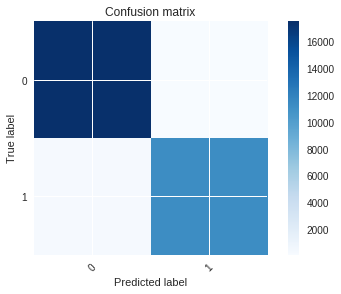

             precision    recall  f1-score   support

          0       0.99      0.99      0.99     17589
          1       0.99      0.98      0.98     11528

avg / total       0.99      0.99      0.99     29117



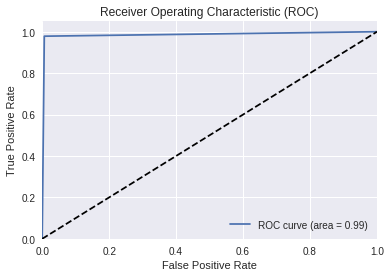

In [85]:
#Logistic Reg

# import the class
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_Train, Y_Train)

# predict the response for new observations
logreg_pred = logreg.predict(X_Test)

#accuracy
score = metrics.accuracy_score(Y_Test, logreg_pred)
print("Final accuracy: {}".format(score))

cm = metrics.confusion_matrix(Y_Test, logreg_pred)  
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()

print(metrics.classification_report(Y_Test, logreg_pred))

plot_roc(logreg_pred,Y_Test)

## SVM

Final accuracy: 0.9921351787615482
[[17496    93]
 [  136 11392]]
Plotting confusion matrix


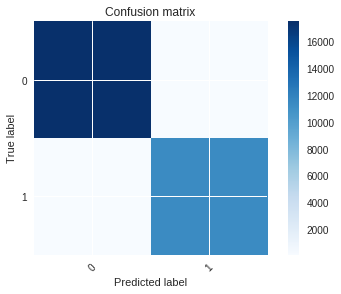

             precision    recall  f1-score   support

          0       0.99      0.99      0.99     17589
          1       0.99      0.99      0.99     11528

avg / total       0.99      0.99      0.99     29117



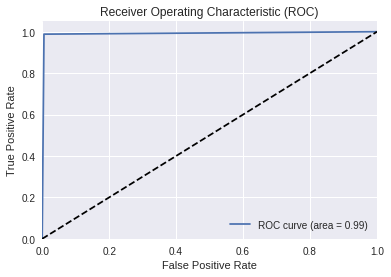

In [133]:
#SVM

from sklearn.svm import SVC
import sklearn.metrics as metrics

clf = SVC(kernel='linear')
clf.fit(X_Train, Y_Train)

svm_pred = clf.predict(X_Test)

#accuracy
score = metrics.accuracy_score(Y_Test, svm_pred)
print("Final accuracy: {}".format(score))

cm = metrics.confusion_matrix(Y_Test, svm_pred)  
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()

print(metrics.classification_report(Y_Test, svm_pred))

plot_roc(svm_pred,Y_Test)

## Nearnest Neighbor 

Final accuracy: 0.9964282034550263
[[17554    35]
 [   69 11459]]
Plotting confusion matrix


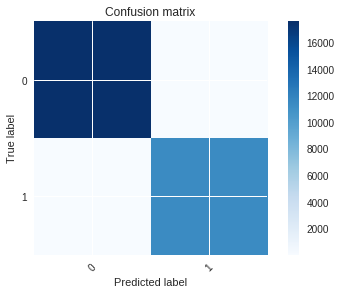

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17589
          1       1.00      0.99      1.00     11528

avg / total       1.00      1.00      1.00     29117



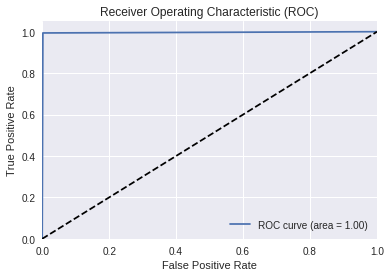

In [134]:
# Nearnest Neighbor

from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_Train, Y_Train)
knn_pred = knn.predict(X_Test)
knn_pred

#accuracy
score = metrics.accuracy_score(Y_Test, knn_pred)
print("Final accuracy: {}".format(score))

cm = metrics.confusion_matrix(Y_Test, knn_pred)  
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()

print(metrics.classification_report(Y_Test, knn_pred))

plot_roc(knn_pred,Y_Test)

## Gaussian Naive Bayes 

In [ ]:
#Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
import sklearn.metrics as metrics
clf = GaussianNB()
clf.fit(X_Train, Y_Train)
gnb_pred = clf.predict(X_Test)

#accuracy
score = metrics.accuracy_score(Y_Test, gnb_pred)
print("Final accuracy: {}".format(score))

cm = metrics.confusion_matrix(Y_Test, gnb_pred)  
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()

print(metrics.classification_report(Y_Test, gnb_pred))

plot_roc(gnb_pred,Y_Test)

## **Tensorflow**

In [123]:
#one hot encoding on outcome
y=pd.get_dummies(df_network['outcome'])
y.shape

(145585, 2)

In [0]:
#splting Data into traing and testing
x_train, x_test, y_train, y_test = train_test_split (x, y, test_size=0.20, random_state=45)

In [41]:
 # Activation=relu && optimizer = adam
checkpointer = ModelCheckpoint(filepath="best_weights1.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(3):
    print(i)
    model_adam_relu = Sequential()
    model_adam_relu.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model_adam_relu.add(Dense(20, activation='relu')) # Hidden 2
    model_adam_relu.add(Dense(y.shape[1], activation='softmax')) # Output
    #rms=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
    model_adam_relu.compile(loss='categorical_crossentropy', optimizer=adam)
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')
    model_adam_relu.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=150)
print('Training finished...Loading the best model')  
print()
model_adam_relu.load_weights('best_weights.hdf5') # load weights from best model

0
Train on 116468 samples, validate on 29117 samples
Epoch 1/150
 - 20s - loss: 0.0382 - val_loss: 0.0150
Epoch 2/150
 - 20s - loss: 0.0113 - val_loss: 0.0096
Epoch 3/150
 - 20s - loss: 0.0078 - val_loss: 0.0079
Epoch 4/150
 - 20s - loss: 0.0068 - val_loss: 0.0074
Epoch 5/150
 - 20s - loss: 0.0066 - val_loss: 0.0085
Epoch 00005: early stopping
Training finished...Loading the best model



Accuracy: 0.9979736923446784
[[17541    32]
 [   27 11517]]
Plotting confusion matrix


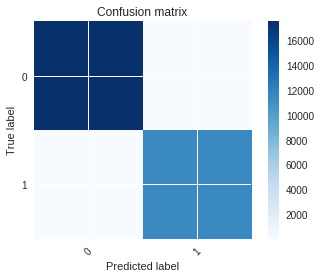

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17573
          1       1.00      1.00      1.00     11544

avg / total       1.00      1.00      1.00     29117



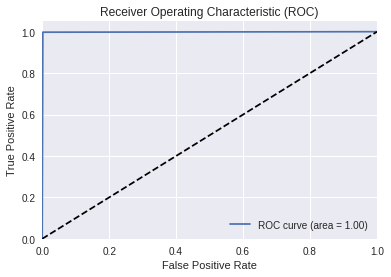

In [42]:
# Measure accuracy
pred = model_adam_relu.predict(x_test)
pred_attack = np.argmax(pred,axis=1)
y_testarray=y_test.values
y_true = np.argmax(y_testarray,axis=1)
correct = metrics.accuracy_score(y_true, pred_attack)
print("Accuracy: {}".format(correct))
y_true

cm = metrics.confusion_matrix(y_true, pred_attack)  
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()

print(metrics.classification_report(y_true, pred_attack))

plot_roc(pred_attack,y_true)

In [53]:
 # Activation=relu && optimizer = sgd
checkpointer = ModelCheckpoint(filepath="best_weights_relu_sgd.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(3):
    print(i)
    model_sgd_relu = Sequential()
    model_sgd_relu.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model_sgd_relu.add(Dense(20, activation='relu')) # Hidden 2
    model_sgd_relu.add(Dense(y.shape[1], activation='softmax')) # Output
    model_sgd_relu.compile(loss='categorical_crossentropy', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')
    model_sgd_relu.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=150)
print('Training finished...Loading the best model')  
print()
model_sgd_relu.load_weights('best_weights_relu_sgd.hdf5') # load weights from best model

0
Train on 116468 samples, validate on 29117 samples
Epoch 1/150
 - 16s - loss: 0.0920 - val_loss: 0.0586
Epoch 2/150
 - 17s - loss: 0.0488 - val_loss: 0.0444
Epoch 3/150
 - 16s - loss: 0.0400 - val_loss: 0.0378
Epoch 4/150
 - 15s - loss: 0.0354 - val_loss: 0.0343
Epoch 5/150
 - 15s - loss: 0.0322 - val_loss: 0.0312
Epoch 6/150
 - 15s - loss: 0.0299 - val_loss: 0.0291
Epoch 7/150
 - 16s - loss: 0.0281 - val_loss: 0.0287
Epoch 8/150
 - 15s - loss: 0.0267 - val_loss: 0.0293
Epoch 00008: early stopping
1
Train on 116468 samples, validate on 29117 samples
Epoch 1/150
 - 16s - loss: 0.0976 - val_loss: 0.0599
Epoch 2/150
 - 15s - loss: 0.0514 - val_loss: 0.0479
Epoch 3/150
 - 15s - loss: 0.0428 - val_loss: 0.0409
Epoch 4/150
 - 15s - loss: 0.0381 - val_loss: 0.0380
Epoch 5/150
 - 15s - loss: 0.0351 - val_loss: 0.0345
Epoch 6/150
 - 15s - loss: 0.0326 - val_loss: 0.0323
Epoch 7/150
 - 15s - loss: 0.0308 - val_loss: 0.0307
Epoch 8/150
 - 15s - loss: 0.0291 - val_loss: 0.0292
Epoch 9/150
 - 15s

In [54]:
# Measure accuracy
pred = model_sgd_relu.predict(x_test)
pred_attack = np.argmax(pred,axis=1)
y_testarray=y_test.values
y_true = np.argmax(y_testarray,axis=1)
correct = metrics.accuracy_score(y_true, pred_attack)
print("Accuracy: {}".format(correct))

Accuracy: 0.9979736923446784


[[17541    32]
 [   27 11517]]
Plotting confusion matrix


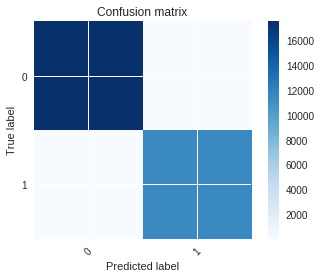

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17573
          1       1.00      1.00      1.00     11544

avg / total       1.00      1.00      1.00     29117



In [56]:
from sklearn.metrics import confusion_matrix, classification_report
# Compute confusion matrix
cm = confusion_matrix(y_true, pred_attack)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()
print(classification_report(y_true, pred_attack))

## CNN

In [42]:
print("Shape of x_train: {}".format(X_Train.shape))
print("Shape of y_train: {}".format(Y_Train.shape))
print()
print("Shape of x_test: {}".format(X_Test.shape))
print("Shape of y_test: {}".format(Y_Test.shape))

Shape of x_train: (116468, 121)
Shape of y_train: (116468,)

Shape of x_test: (29117, 121)
Shape of y_test: (29117,)


In [105]:
#Reshape 2D
cnn_x_train = X_Train.reshape(X_Train.shape[0], 1, X_Train.shape[1], 1)
cnn_x_test = X_Test.reshape(X_Test.shape[0], 1 , X_Test.shape[1], 1)
#reshape 1D
#cnn_x_train = X_Train.reshape(X_Train.shape[0], 1, 1,X_Train.shape[1])
#cnn_x_test = X_Test.reshape(X_Test.shape[0], 1 ,1, X_Test.shape[1])

print("Shape of x_train: {}".format(cnn_x_train.shape))
print("Shape of x_test: {}".format(cnn_x_test.shape))

Shape of x_train: (116468, 1, 121, 1)
Shape of x_test: (29117, 1, 121, 1)


In [0]:
num_classes = 2

# Converts a class vector (integers) to binary class matrix.   One-hot encoding!  Use with categorical_crossentropy.
cnn_y_train = keras.utils.to_categorical(Y_Train, num_classes)
cnn_y_test = keras.utils.to_categorical(Y_Test, num_classes)

In [107]:
cnn_y_train.shape, cnn_y_test.shape

((116468, 2), (29117, 2))

In [108]:
# Define batch_size and # of epochs
batch_size = 128
img_rows= 1
img_cols= 121
input_shape = (img_rows, img_cols, 1)
input_shape

(1, 121, 1)

In [109]:
#kernal size = 1,5    stride = 1,1     activation='relu'
import time
checkpointer = ModelCheckpoint(filepath="best_weights_cnn_15_relu.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    print(i)
    model_cnn = Sequential()
    model_cnn.add(Conv2D(32, kernel_size=(1, 5), strides=(1, 1),
                     activation='relu', padding='valid',
                     input_shape=input_shape))
    model_cnn.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    model_cnn.add(Conv2D(64, (1, 5), activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(1, 2)))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(1000, activation='relu'))
    model_cnn.add(Dense(num_classes, activation='softmax'))
    
    model_cnn.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')

    start_time = time.time()

    model_cnn.fit(cnn_x_train,cnn_y_train,
              batch_size=batch_size,
              epochs=10,
              verbose=2,
              callbacks=[monitor,checkpointer],
              validation_data=(cnn_x_test,cnn_y_test))

    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time)))
model_cnn.load_weights('best_weights_cnn_15_relu.hdf5') # load weights from best model

0
Train on 116468 samples, validate on 29117 samples
Epoch 1/10
 - 12s - loss: 0.0270 - acc: 0.9920 - val_loss: 0.0098 - val_acc: 0.9966
Epoch 2/10
 - 11s - loss: 0.0095 - acc: 0.9970 - val_loss: 0.0079 - val_acc: 0.9973
Epoch 3/10
 - 11s - loss: 0.0074 - acc: 0.9979 - val_loss: 0.0072 - val_acc: 0.9979
Epoch 4/10
 - 11s - loss: 0.0069 - acc: 0.9980 - val_loss: 0.0061 - val_acc: 0.9981
Epoch 5/10
 - 12s - loss: 0.0060 - acc: 0.9982 - val_loss: 0.0043 - val_acc: 0.9987
Epoch 6/10
 - 11s - loss: 0.0057 - acc: 0.9984 - val_loss: 0.0049 - val_acc: 0.9986
Epoch 7/10
 - 11s - loss: 0.0048 - acc: 0.9985 - val_loss: 0.0053 - val_acc: 0.9987
Epoch 00007: early stopping
Elapsed time: 0:01:19.35
1
Train on 116468 samples, validate on 29117 samples
Epoch 1/10
 - 12s - loss: 0.0306 - acc: 0.9908 - val_loss: 0.0093 - val_acc: 0.9975
Epoch 2/10
 - 11s - loss: 0.0099 - acc: 0.9972 - val_loss: 0.0080 - val_acc: 0.9973
Epoch 3/10
 - 11s - loss: 0.0080 - acc: 0.9976 - val_loss: 0.0069 - val_acc: 0.9978
E

Accuracy: 0.9986949204931826
[[17566    23]
 [   15 11513]]
Plotting confusion matrix


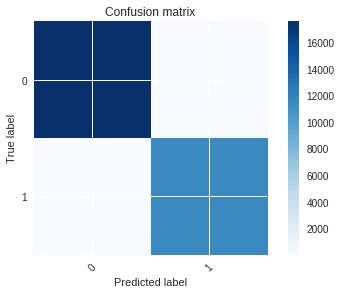

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17589
          1       1.00      1.00      1.00     11528

avg / total       1.00      1.00      1.00     29117



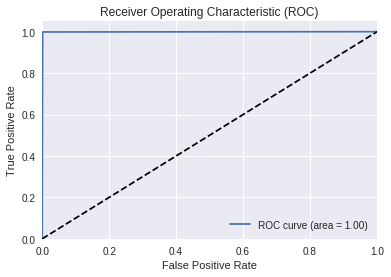

In [110]:
# Measure accuracy
pred = model_cnn.predict(cnn_x_test)
pred_attack = np.argmax(pred,axis=1)
y_testarray=cnn_y_test
y_true = np.argmax(y_testarray,axis=1)
correct = metrics.accuracy_score(y_true, pred_attack)
print("Accuracy: {}".format(correct))
y_true

cm = metrics.confusion_matrix(y_true, pred_attack)  
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()

print(metrics.classification_report(y_true, pred_attack))

plot_roc(pred_attack,y_true)

In [55]:
#kernal size = 1,3    stride = 1,1     activation='relu'
import time
checkpointer = ModelCheckpoint(filepath="best_weights_cnn_13_relu.hdf5", verbose=0, save_best_only=True) # save best model

model_cnn = Sequential()
model_cnn.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1),activation='relu', padding='valid',input_shape=input_shape))
model_cnn.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
model_cnn.add(Conv2D(64, (1, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(1, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(1000, activation='relu'))
model_cnn.add(Dense(num_classes, activation='softmax'))
    
model_cnn.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')

start_time = time.time()

model_cnn.fit(cnn_x_train,cnn_y_train,
              batch_size=batch_size,
              epochs=10,
              verbose=2,
              callbacks=[monitor,checkpointer],
              validation_data=(cnn_x_test,cnn_y_test))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))
model_cnn.load_weights('best_weights_cnn_13_relu.hdf5') # load weights from best model

Train on 116468 samples, validate on 29117 samples
Epoch 1/10
 - 69s - loss: 0.0308 - acc: 0.9904 - val_loss: 0.0119 - val_acc: 0.9965
Epoch 2/10
 - 69s - loss: 0.0105 - acc: 0.9970 - val_loss: 0.0069 - val_acc: 0.9979
Epoch 3/10
 - 69s - loss: 0.0084 - acc: 0.9976 - val_loss: 0.0106 - val_acc: 0.9973
Epoch 4/10
 - 68s - loss: 0.0074 - acc: 0.9977 - val_loss: 0.0106 - val_acc: 0.9967
Epoch 5/10
 - 68s - loss: 0.0066 - acc: 0.9980 - val_loss: 0.0066 - val_acc: 0.9973
Epoch 6/10
 - 68s - loss: 0.0061 - acc: 0.9981 - val_loss: 0.0060 - val_acc: 0.9980
Epoch 7/10
 - 69s - loss: 0.0054 - acc: 0.9985 - val_loss: 0.0045 - val_acc: 0.9986
Epoch 8/10
 - 67s - loss: 0.0051 - acc: 0.9985 - val_loss: 0.0057 - val_acc: 0.9983
Epoch 9/10
 - 67s - loss: 0.0049 - acc: 0.9985 - val_loss: 0.0093 - val_acc: 0.9964
Epoch 10/10
 - 67s - loss: 0.0045 - acc: 0.9987 - val_loss: 0.0051 - val_acc: 0.9986
Elapsed time: 0:11:21.82


Accuracy: 0.9985575437029914
Plotting confusion matrix


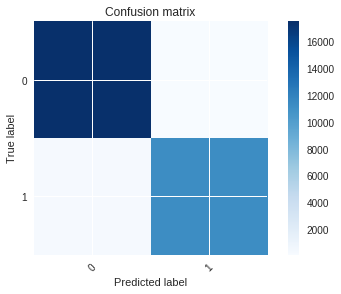

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17589
          1       1.00      1.00      1.00     11528

avg / total       1.00      1.00      1.00     29117



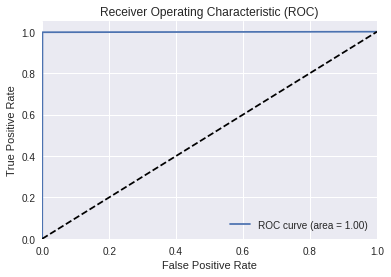

In [60]:
# Measure accuracy
pred = model_cnn.predict(cnn_x_test)
pred_attack = np.argmax(pred,axis=1)
y_testarray=cnn_y_test
y_true = np.argmax(y_testarray,axis=1)
correct = metrics.accuracy_score(y_true, pred_attack)
print("Accuracy: {}".format(correct))
y_true

cm = metrics.confusion_matrix(y_true, pred_attack)  
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()

print(metrics.classification_report(y_true, pred_attack))

plot_roc(pred_attack,y_true)

In [47]:
#kernal size = 1,5    stride = 1,1     activation='tanh'
import time
checkpointer = ModelCheckpoint(filepath="best_weights_cnn_15_tanh.hdf5", verbose=0, save_best_only=True) # save best model

model_cnn = Sequential()
model_cnn.add(Conv2D(32, kernel_size=(1, 5), strides=(1, 1),activation='tanh', padding='valid',input_shape=input_shape))
model_cnn.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
model_cnn.add(Conv2D(64, (1, 5), activation='tanh'))
model_cnn.add(MaxPooling2D(pool_size=(1, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(1000, activation='tanh'))
model_cnn.add(Dense(num_classes, activation='softmax'))
    
model_cnn.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')

start_time = time.time()

model_cnn.fit(cnn_x_train,cnn_y_train,
              batch_size=batch_size,
              epochs=10,
              verbose=2,
              callbacks=[monitor,checkpointer],
              validation_data=(cnn_x_test,cnn_y_test))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))
model_cnn.load_weights('best_weights_cnn_15_tanh.hdf5') # load weights from best model

Train on 116468 samples, validate on 29117 samples
Epoch 1/10
 - 10s - loss: 0.0354 - acc: 0.9894 - val_loss: 0.0316 - val_acc: 0.9912
Epoch 2/10
 - 9s - loss: 0.0237 - acc: 0.9928 - val_loss: 0.0189 - val_acc: 0.9942
Epoch 3/10
 - 9s - loss: 0.0202 - acc: 0.9941 - val_loss: 0.0190 - val_acc: 0.9933
Epoch 4/10
 - 9s - loss: 0.0185 - acc: 0.9944 - val_loss: 0.0172 - val_acc: 0.9950
Epoch 5/10
 - 9s - loss: 0.0171 - acc: 0.9948 - val_loss: 0.0264 - val_acc: 0.9916
Epoch 6/10
 - 9s - loss: 0.0166 - acc: 0.9951 - val_loss: 0.0127 - val_acc: 0.9957
Epoch 7/10
 - 9s - loss: 0.0149 - acc: 0.9953 - val_loss: 0.0126 - val_acc: 0.9958
Epoch 8/10
 - 9s - loss: 0.0135 - acc: 0.9960 - val_loss: 0.0152 - val_acc: 0.9943
Epoch 00008: early stopping
Elapsed time: 0:01:12.81


Accuracy: 0.994333207404609
Plotting confusion matrix


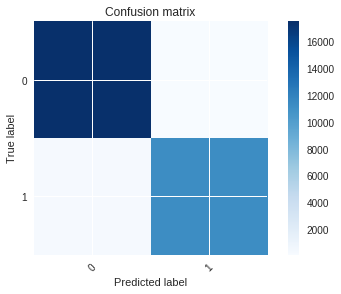

             precision    recall  f1-score   support

          0       0.99      1.00      1.00     17589
          1       1.00      0.99      0.99     11528

avg / total       0.99      0.99      0.99     29117



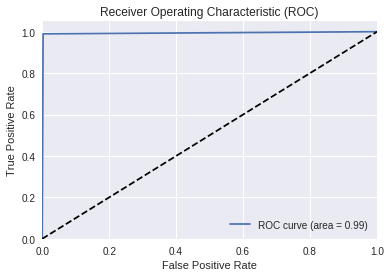

In [48]:
# Measure accuracy
pred = model_cnn.predict(cnn_x_test)
pred_attack = np.argmax(pred,axis=1)
y_testarray=cnn_y_test
y_true = np.argmax(y_testarray,axis=1)
correct = metrics.accuracy_score(y_true, pred_attack)
print("Accuracy: {}".format(correct))
y_true

cm = metrics.confusion_matrix(y_true, pred_attack)  
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()

print(metrics.classification_report(y_true, pred_attack))

plot_roc(pred_attack,y_true)

In [49]:
#kernal size = 1,3    stride = 1,1     activation='tanh'
import time
checkpointer = ModelCheckpoint(filepath="best_weights_cnn_13_tanh.hdf5", verbose=0, save_best_only=True) # save best model

model_cnn = Sequential()
model_cnn.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1),activation='tanh', padding='valid',input_shape=input_shape))
model_cnn.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
model_cnn.add(Conv2D(64, (1, 3), activation='tanh'))
model_cnn.add(MaxPooling2D(pool_size=(1, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(1000, activation='tanh'))
model_cnn.add(Dense(num_classes, activation='softmax'))
    
model_cnn.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')

start_time = time.time()

model_cnn.fit(cnn_x_train,cnn_y_train,
              batch_size=batch_size,
              epochs=10,
              verbose=2,
              callbacks=[monitor,checkpointer],
              validation_data=(cnn_x_test,cnn_y_test))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))
model_cnn.load_weights('best_weights_cnn_13_tanh.hdf5') # load weights from best model

Train on 116468 samples, validate on 29117 samples
Epoch 1/10
 - 10s - loss: 0.0380 - acc: 0.9876 - val_loss: 0.0231 - val_acc: 0.9925
Epoch 2/10
 - 9s - loss: 0.0243 - acc: 0.9925 - val_loss: 0.0187 - val_acc: 0.9942
Epoch 3/10
 - 9s - loss: 0.0206 - acc: 0.9938 - val_loss: 0.0165 - val_acc: 0.9946
Epoch 4/10
 - 9s - loss: 0.0194 - acc: 0.9943 - val_loss: 0.0194 - val_acc: 0.9942
Epoch 5/10
 - 9s - loss: 0.0175 - acc: 0.9947 - val_loss: 0.0238 - val_acc: 0.9913
Epoch 00005: early stopping
Elapsed time: 0:00:45.31


Accuracy: 0.9913109180204005
Plotting confusion matrix


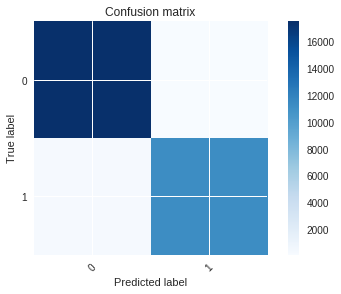

             precision    recall  f1-score   support

          0       1.00      0.99      0.99     17589
          1       0.98      1.00      0.99     11528

avg / total       0.99      0.99      0.99     29117



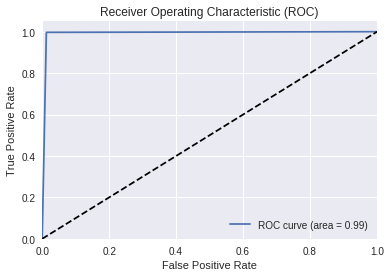

In [50]:
# Measure accuracy
pred = model_cnn.predict(cnn_x_test)
pred_attack = np.argmax(pred,axis=1)
y_testarray=cnn_y_test
y_true = np.argmax(y_testarray,axis=1)
correct = metrics.accuracy_score(y_true, pred_attack)
print("Accuracy: {}".format(correct))
y_true

cm = metrics.confusion_matrix(y_true, pred_attack)  
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()

print(metrics.classification_report(y_true, pred_attack))

plot_roc(pred_attack,y_true)

In [51]:
#kernal size = 1,5    stride = 1,1     activation='sigmoid'
import time
checkpointer = ModelCheckpoint(filepath="best_weights_cnn_13_sigmoid.hdf5", verbose=0, save_best_only=True) # save best model

model_cnn = Sequential()
model_cnn.add(Conv2D(32, kernel_size=(1, 5), strides=(1, 1),activation='sigmoid', padding='valid',input_shape=input_shape))
model_cnn.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
model_cnn.add(Conv2D(64, (1, 5), activation='sigmoid'))
model_cnn.add(MaxPooling2D(pool_size=(1, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(1000, activation='sigmoid'))
model_cnn.add(Dense(num_classes, activation='softmax'))
    
model_cnn.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')

start_time = time.time()

model_cnn.fit(cnn_x_train,cnn_y_train,
              batch_size=batch_size,
              epochs=10,
              verbose=2,
              callbacks=[monitor,checkpointer],
              validation_data=(cnn_x_test,cnn_y_test))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))
model_cnn.load_weights('best_weights_cnn_13_sigmoid.hdf5') # load weights from best model

Train on 116468 samples, validate on 29117 samples
Epoch 1/10
 - 10s - loss: 0.2388 - acc: 0.8915 - val_loss: 0.0691 - val_acc: 0.9832
Epoch 2/10
 - 9s - loss: 0.0664 - acc: 0.9820 - val_loss: 0.0567 - val_acc: 0.9848
Epoch 3/10
 - 9s - loss: 0.0522 - acc: 0.9852 - val_loss: 0.0461 - val_acc: 0.9864
Epoch 4/10
 - 9s - loss: 0.0443 - acc: 0.9861 - val_loss: 0.0458 - val_acc: 0.9858
Epoch 5/10
 - 9s - loss: 0.0386 - acc: 0.9873 - val_loss: 0.0350 - val_acc: 0.9885
Epoch 6/10
 - 9s - loss: 0.0326 - acc: 0.9893 - val_loss: 0.0282 - val_acc: 0.9910
Epoch 7/10
 - 9s - loss: 0.0286 - acc: 0.9908 - val_loss: 0.0317 - val_acc: 0.9906
Epoch 8/10
 - 9s - loss: 0.0257 - acc: 0.9918 - val_loss: 0.0203 - val_acc: 0.9933
Epoch 9/10
 - 9s - loss: 0.0247 - acc: 0.9923 - val_loss: 0.0181 - val_acc: 0.9947
Epoch 10/10
 - 9s - loss: 0.0204 - acc: 0.9937 - val_loss: 0.0184 - val_acc: 0.9930
Elapsed time: 0:01:30.66


Accuracy: 0.9930281278977917
Plotting confusion matrix


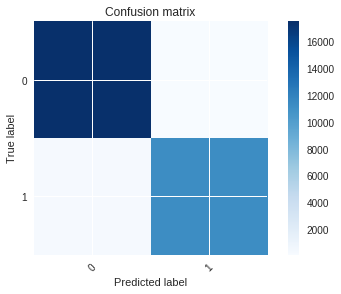

             precision    recall  f1-score   support

          0       0.99      1.00      0.99     17589
          1       1.00      0.99      0.99     11528

avg / total       0.99      0.99      0.99     29117



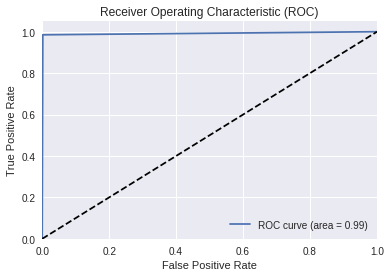

In [52]:
# Measure accuracy
pred = model_cnn.predict(cnn_x_test)
pred_attack = np.argmax(pred,axis=1)
y_testarray=cnn_y_test
y_true = np.argmax(y_testarray,axis=1)
correct = metrics.accuracy_score(y_true, pred_attack)
print("Accuracy: {}".format(correct))
y_true

cm = metrics.confusion_matrix(y_true, pred_attack)  
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()

print(metrics.classification_report(y_true, pred_attack))

plot_roc(pred_attack,y_true)

In [53]:
#kernal size = 1,3     activation='sigmoid'
import time
checkpointer = ModelCheckpoint(filepath="best_weights_cnn_15_sigmoid.hdf5", verbose=0, save_best_only=True) # save best model

model_cnn = Sequential()
model_cnn.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1),activation='sigmoid', padding='valid',input_shape=input_shape))
model_cnn.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
model_cnn.add(Conv2D(64, (1, 3), activation='sigmoid'))
model_cnn.add(MaxPooling2D(pool_size=(1, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(1000, activation='sigmoid'))
model_cnn.add(Dense(num_classes, activation='softmax'))
    
model_cnn.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')

start_time = time.time()

model_cnn.fit(cnn_x_train,cnn_y_train,
              batch_size=batch_size,
              epochs=10,
              verbose=2,
              callbacks=[monitor,checkpointer],
              validation_data=(cnn_x_test,cnn_y_test))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))
model_cnn.load_weights('best_weights_cnn_15_sigmoid.hdf5') # load weights from best model

Train on 116468 samples, validate on 29117 samples
Epoch 1/10
 - 10s - loss: 0.3012 - acc: 0.8624 - val_loss: 0.0715 - val_acc: 0.9818
Epoch 2/10
 - 9s - loss: 0.0685 - acc: 0.9814 - val_loss: 0.0557 - val_acc: 0.9846
Epoch 3/10
 - 9s - loss: 0.0553 - acc: 0.9846 - val_loss: 0.0504 - val_acc: 0.9857
Epoch 4/10
 - 9s - loss: 0.0460 - acc: 0.9858 - val_loss: 0.0423 - val_acc: 0.9862
Epoch 5/10
 - 9s - loss: 0.0389 - acc: 0.9873 - val_loss: 0.0349 - val_acc: 0.9890
Epoch 6/10
 - 9s - loss: 0.0345 - acc: 0.9888 - val_loss: 0.0279 - val_acc: 0.9901
Epoch 7/10
 - 9s - loss: 0.0318 - acc: 0.9897 - val_loss: 0.0245 - val_acc: 0.9911
Epoch 8/10
 - 9s - loss: 0.0268 - acc: 0.9913 - val_loss: 0.0198 - val_acc: 0.9934
Epoch 9/10
 - 9s - loss: 0.0238 - acc: 0.9925 - val_loss: 0.0168 - val_acc: 0.9946
Epoch 10/10
 - 9s - loss: 0.0189 - acc: 0.9941 - val_loss: 0.0139 - val_acc: 0.9959
Elapsed time: 0:01:30.33


Accuracy: 0.9958786962942611
Plotting confusion matrix


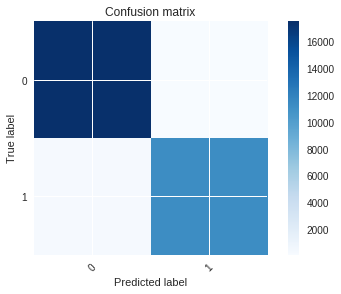

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17589
          1       1.00      0.99      0.99     11528

avg / total       1.00      1.00      1.00     29117



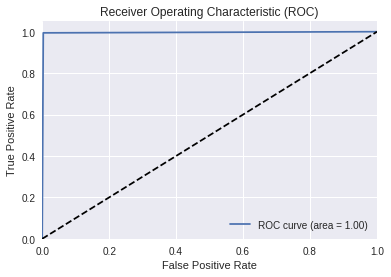

In [54]:
# Measure accuracy
pred = model_cnn.predict(cnn_x_test)
pred_attack = np.argmax(pred,axis=1)
y_testarray=cnn_y_test
y_true = np.argmax(y_testarray,axis=1)
correct = metrics.accuracy_score(y_true, pred_attack)
print("Accuracy: {}".format(correct))
y_true

cm = metrics.confusion_matrix(y_true, pred_attack)  
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()

print(metrics.classification_report(y_true, pred_attack))

plot_roc(pred_attack,y_true)

In [55]:
#kernal size = 1,3    stride = 1,1     activation='sigmoid'
import time
checkpointer = ModelCheckpoint(filepath="best_weights_cnn_15_sigmoid_nuron50100.hdf5", verbose=0, save_best_only=True) # save best model

model_cnn = Sequential()
model_cnn.add(Conv2D(50, kernel_size=(1, 3), strides=(1, 1),activation='sigmoid', padding='valid',input_shape=input_shape))
model_cnn.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
model_cnn.add(Conv2D(100, (1, 3), activation='sigmoid'))
model_cnn.add(MaxPooling2D(pool_size=(1, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(1000, activation='sigmoid'))
model_cnn.add(Dense(num_classes, activation='softmax'))
    
model_cnn.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')

start_time = time.time()

model_cnn.fit(cnn_x_train,cnn_y_train,
              batch_size=batch_size,
              epochs=10,
              verbose=2,
              callbacks=[monitor,checkpointer],
              validation_data=(cnn_x_test,cnn_y_test))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))
model_cnn.load_weights('best_weights_cnn_15_sigmoid_nuron50100.hdf5') # load weights from best model

Train on 116468 samples, validate on 29117 samples
Epoch 1/10
 - 12s - loss: 0.2971 - acc: 0.8634 - val_loss: 0.0769 - val_acc: 0.9804
Epoch 2/10
 - 11s - loss: 0.0636 - acc: 0.9832 - val_loss: 0.0528 - val_acc: 0.9871
Epoch 3/10
 - 11s - loss: 0.0499 - acc: 0.9859 - val_loss: 0.0431 - val_acc: 0.9878
Epoch 4/10
 - 11s - loss: 0.0413 - acc: 0.9871 - val_loss: 0.0408 - val_acc: 0.9871
Epoch 5/10
 - 11s - loss: 0.0344 - acc: 0.9888 - val_loss: 0.0291 - val_acc: 0.9901
Epoch 6/10
 - 11s - loss: 0.0279 - acc: 0.9910 - val_loss: 0.0226 - val_acc: 0.9926
Epoch 7/10
 - 11s - loss: 0.0245 - acc: 0.9920 - val_loss: 0.0170 - val_acc: 0.9940
Epoch 8/10
 - 11s - loss: 0.0208 - acc: 0.9937 - val_loss: 0.0168 - val_acc: 0.9937
Epoch 9/10
 - 11s - loss: 0.0167 - acc: 0.9950 - val_loss: 0.0149 - val_acc: 0.9951
Epoch 10/10
 - 11s - loss: 0.0138 - acc: 0.9959 - val_loss: 0.0100 - val_acc: 0.9967
Elapsed time: 0:01:50.45


Accuracy: 0.9967029570354089
Plotting confusion matrix


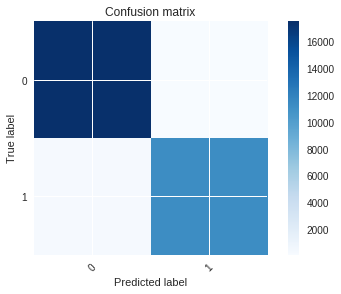

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17589
          1       1.00      0.99      1.00     11528

avg / total       1.00      1.00      1.00     29117



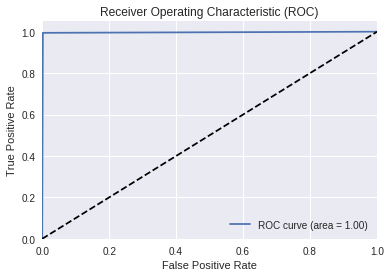

In [56]:
# Measure accuracy
pred = model_cnn.predict(cnn_x_test)
pred_attack = np.argmax(pred,axis=1)
y_testarray=cnn_y_test
y_true = np.argmax(y_testarray,axis=1)
correct = metrics.accuracy_score(y_true, pred_attack)
print("Accuracy: {}".format(correct))
y_true

cm = metrics.confusion_matrix(y_true, pred_attack)  
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()

print(metrics.classification_report(y_true, pred_attack))

plot_roc(pred_attack,y_true)

## Additional Feature
**Multi-Class Classification using CNN**

In [12]:
encode_text_index(df_network, 'outcome')


array(['back.', 'buffer_overflow.', 'ftp_write.', 'guess_passwd.',
       'imap.', 'ipsweep.', 'land.', 'loadmodule.', 'multihop.',
       'neptune.', 'nmap.', 'normal.', 'perl.', 'phf.', 'pod.',
       'portsweep.', 'rootkit.', 'satan.', 'smurf.', 'spy.', 'teardrop.',
       'warezclient.', 'warezmaster.'], dtype=object)

In [0]:
x,y = to_xy(df_network, 'outcome')

In [17]:
x.shape,y.shape

((145585, 121), (145585, 23))

In [18]:
from sklearn.model_selection import train_test_split
X_Train, X_Test, Y_Train, Y_Test = train_test_split(x, y, test_size=0.2, random_state=42)

X_Train.shape, X_Test.shape, Y_Train.shape, Y_Test.shape

((116468, 121), (29117, 121), (116468, 23), (29117, 23))

In [0]:
Y_Train[0:5]

In [19]:
#Reshape 2D
cnn_x_train = X_Train.reshape(X_Train.shape[0], 1, X_Train.shape[1], 1)
cnn_x_test = X_Test.reshape(X_Test.shape[0], 1 , X_Test.shape[1], 1)
#reshape 1D
#cnn_x_train = X_Train.reshape(X_Train.shape[0], 1, 1,X_Train.shape[1])
#cnn_x_test = X_Test.reshape(X_Test.shape[0], 1 ,1, X_Test.shape[1])

print("Shape of x_train: {}".format(cnn_x_train.shape))
print("Shape of x_test: {}".format(cnn_x_test.shape))

Shape of x_train: (116468, 1, 121, 1)
Shape of x_test: (29117, 1, 121, 1)


In [20]:
# Define batch_size and # of epochs
batch_size = 128
img_rows= 1
img_cols= 121
input_shape = (img_rows, img_cols, 1)
input_shape

(1, 121, 1)

In [21]:
#kernal size = 1,3     activation='relu'
import time
checkpointer = ModelCheckpoint(filepath="best_weights_cnn_extra.hdf5", verbose=0, save_best_only=True) # save best model

model_cnn = Sequential()
model_cnn.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1),activation='relu', padding='valid',input_shape=input_shape))
model_cnn.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
model_cnn.add(Conv2D(64, (1, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(1, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(1000, activation='relu'))
model_cnn.add(Dense(23, activation='softmax'))
    
model_cnn.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')

start_time = time.time()

model_cnn.fit(cnn_x_train,Y_Train,
              batch_size=batch_size,
              epochs=10,
              verbose=2,
              callbacks=[monitor,checkpointer],
              validation_data=(cnn_x_test,Y_Test))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))
model_cnn.load_weights('best_weights_cnn_extra.hdf5') # load weights from best model

Train on 116468 samples, validate on 29117 samples
Epoch 1/10
 - 10s - loss: 0.0606 - acc: 0.9878 - val_loss: 0.0168 - val_acc: 0.9956
Epoch 2/10
 - 9s - loss: 0.0148 - acc: 0.9960 - val_loss: 0.0114 - val_acc: 0.9971
Epoch 3/10
 - 9s - loss: 0.0111 - acc: 0.9972 - val_loss: 0.0091 - val_acc: 0.9978
Epoch 4/10
 - 9s - loss: 0.0096 - acc: 0.9974 - val_loss: 0.0096 - val_acc: 0.9976
Epoch 5/10
 - 9s - loss: 0.0087 - acc: 0.9975 - val_loss: 0.0086 - val_acc: 0.9975
Epoch 00005: early stopping
Elapsed time: 0:00:45.44


Accuracy: 0.997458529381461
[[  191     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0]
 [    0     3     0     0     0     0     0     0     0     0     2     0
      0     0     0     0     0     0     0     1     0]
 [    0     0     0     0     0     0     0     0     0     0     3     0
      0     0     0     0     0     0     0     2     0]
 [    0     0     0    10     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     1     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0   118     0     0     0     2    17     0
      0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     2     0     0     0     0     0
      0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0

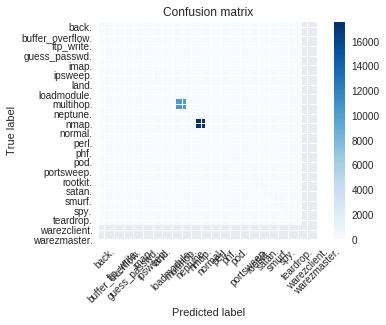

             precision    recall  f1-score   support

          0       0.99      1.00      1.00       191
          1       1.00      0.50      0.67         6
          2       0.00      0.00      0.00         5
          3       0.91      1.00      0.95        10
          4       1.00      1.00      1.00         1
          5       0.99      0.86      0.92       137
          6       1.00      1.00      1.00         2
          8       0.00      0.00      0.00         2
          9       1.00      1.00      1.00     10357
         10       0.92      0.92      0.92        38
         11       1.00      1.00      1.00     17589
         12       0.00      0.00      0.00         0
         13       0.00      0.00      0.00         0
         14       1.00      1.00      1.00        34
         15       0.99      0.95      0.97        92
         16       1.00      1.00      1.00         1
         17       1.00      0.97      0.99       158
         18       1.00      0.99      1.00   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [24]:
# Measure accuracy
pred = model_cnn.predict(cnn_x_test)
pred_attack = np.argmax(pred,axis=1)
y_testarray=Y_Test
y_true = np.argmax(y_testarray,axis=1)
correct = metrics.accuracy_score(y_true, pred_attack)
print("Accuracy: {}".format(correct))
y_true

cm = metrics.confusion_matrix(y_true, pred_attack)  
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()

print(metrics.classification_report(y_true, pred_attack))

**Feature Importance Analysis using Tensorflow Fully Connected Network** 

In [125]:
#feature Extraction
# Activation=relu && optimizer = adam
checkpointer = ModelCheckpoint(filepath="best_weights_feature_ext.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(3):
    print(i)
    model_adam_relu = Sequential()
    model_adam_relu.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model_adam_relu.add(Dense(20, activation='relu')) # Hidden 2
    model_adam_relu.add(Dense(y.shape[1], activation='softmax')) # Output
    #rms=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
    model_adam_relu.compile(loss='categorical_crossentropy', optimizer=adam)
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')
    model_adam_relu.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=150)
print('Training finished...Loading the best model')  
print()
model_adam_relu.load_weights('best_weights_feature_ext.hdf5') # load weights from best model

0
Train on 116468 samples, validate on 29117 samples
Epoch 1/150
 - 25s - loss: 0.0370 - val_loss: 0.0183
Epoch 2/150
 - 24s - loss: 0.0120 - val_loss: 0.0103
Epoch 3/150
 - 25s - loss: 0.0080 - val_loss: 0.0092
Epoch 4/150
 - 25s - loss: 0.0068 - val_loss: 0.0071
Epoch 5/150
 - 27s - loss: 0.0061 - val_loss: 0.0068
Epoch 6/150
 - 26s - loss: 0.0056 - val_loss: 0.0067
Epoch 00006: early stopping
1
Train on 116468 samples, validate on 29117 samples
Epoch 1/150
 - 25s - loss: 0.0349 - val_loss: 0.0122
Epoch 2/150
 - 26s - loss: 0.0104 - val_loss: 0.0080
Epoch 3/150
 - 26s - loss: 0.0075 - val_loss: 0.0075
Epoch 4/150
 - 26s - loss: 0.0068 - val_loss: 0.0089
Epoch 00004: early stopping
2
Train on 116468 samples, validate on 29117 samples
Epoch 1/150
 - 26s - loss: 0.0355 - val_loss: 0.0202
Epoch 2/150
 - 24s - loss: 0.0105 - val_loss: 0.0080
Epoch 3/150
 - 23s - loss: 0.0076 - val_loss: 0.0072
Epoch 4/150
 - 24s - loss: 0.0066 - val_loss: 0.0254
Epoch 00004: early stopping
Training finish

Accuracy: 0.9980767249373218
[[17542    31]
 [   25 11519]]
Plotting confusion matrix


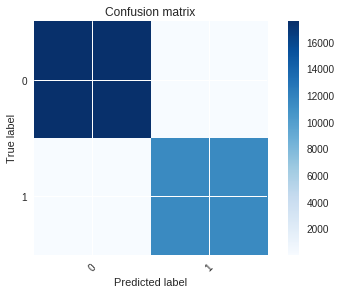

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17573
          1       1.00      1.00      1.00     11544

avg / total       1.00      1.00      1.00     29117



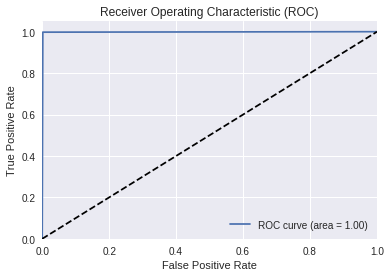

In [126]:
# Measure accuracy
pred = model_adam_relu.predict(x_test)
pred_attack = np.argmax(pred,axis=1)
y_testarray=y_test.values
y_true = np.argmax(y_testarray,axis=1)
correct = metrics.accuracy_score(y_true, pred_attack)
print("Accuracy: {}".format(correct))
y_true

cm = metrics.confusion_matrix(y_true, pred_attack)  
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm,outcome)
plt.show()

print(metrics.classification_report(y_true, pred_attack))

plot_roc(pred_attack,y_true)

In [127]:
# Rank the features
# from IPython.display import display, HTML

names = list(df_network.columns) # x+y column names
names.remove("outcome") # remove the target(y)
rank = perturbation_rank(model_adam_relu, x_test, y_true, names, False)
rank

,name,error,importance
0,dst_host_srv_count,0.357973,1.000000
1,srv_rerror_rate,0.132289,0.369551
2,wrong_fragment,0.064941,0.181412
3,hot,0.058136,0.162404
4,dst_host_same_src_port_rate,0.044542,0.124429
5,flag-REJ,0.040265,0.112479
6,dst_host_count,0.038625,0.107899
7,dst_host_rerror_rate,0.030006,0.083821
8,dst_host_srv_serror_rate,0.024467,0.068348
9,count,0.023925,0.066834


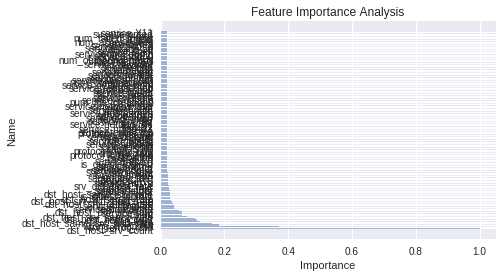

In [129]:
objects = rank['name']
y_pos = np.arange(len(objects))
performance = rank['importance']
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Importance')
plt.ylabel('Name')
plt.title('Feature Importance Analysis')
 
plt.show()